<a href="https://colab.research.google.com/github/shizoda/education/blob/main/machine_learning/transformerWord2Vec_BERT_GPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤖 GPTはどのようにテキストを生成するのか？

こんにちは！この課題では、ChatGPT で使われている「GPT（Generative Pre-trained Transformer）」が、どのようにして人間のように自然な文章を作り出すのか、その基本的な仕組みを4つのステップで学んでいきます。

**この課題のゴール:**
-  単語の意味を数値で表現する「埋め込みベクトル」を理解する。
-  多くの単語の意味を重み付けした「文脈ベクトル」を理解する。
-  BERT と GPT の違いを理解する。
3.  GPTが「次の単語」をどうやって予測しているか理解する。

（注：この教材は、Colabの「ランタイム」メニューから「ランタイムのタイプを変更」を選び、「GPU」が設定されていることを前提としています。）

In [ ]:
#@title 【まず実行】必要なライブラリのインストール
# Transformers ライブラリ（BERTやGPTを使うためのもの）
# tqdm は進捗バーを表示するため
!pip install -q transformers torch tqdm gensim
print("✅ ライブラリのインストールが完了しました。")

#@title GPUの確認
import torch
import tqdm # tqdm のインポート（永続的指示）

# GPUが利用可能か確認
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✅ GPUが利用可能です。デバイス: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("⚠️ GPUが利用できません。CPUで実行します（少し時間がかかるかもしれません）。")

# 📚 ステップ 0: Word2Vecデモ — 「意味」って計算できるの？

GPTやBERTといったAIが登場する前に、とても活躍した「Word2Vec（ワード・トゥ・ベック）」という技術があります。

これも、単語を「数値のリスト」に変換する技術です。この数値リストのすごいところは、単なる数値の羅列ではなく、**単語の「意味」がその数値に反映される**点にあります。さらに、その数値を使って **「意味」を計算** することもできます。

## 🧮 有名な計算式: king - man + woman = queen

Word2Vecの世界で最も有名なのが、この計算式です。

> `(king) - (man) + (woman) ≈ (queen)`

「`king`（王様）」が持つ数値から「`man`（男性）」っぽさを引き算し、そこに「`woman`（女性）」っぽさを足し算すると、その計算結果は「`queen`（女王）」が持つ数値と、ほぼ同じ値になります。

---

## 🧭 なぜ、そんな計算ができるの？

Word2Vecが単語を「**意味の空間**」に配置するからです。

**1. 「似たもの」は近くに置く**
まず、この地図では、似たような文脈で使われる単語（例：「銀行」と「信用金庫」）は、近い場所に配置されます。

**2. 「関係性」を「方向」として揃える（ここが重要！）**
Word2Vecの本当にすごい点は、単語と単語の「関係性」も地図上の「方向」として学習することです。

例えば、
* 「`man`（男性）」という点から「`king`（王様）」という点に向かう「方向」
* 「`woman`（女性）」という点から「`queen`（女王）」という点に向かう「方向」

この2つの「方向」は、どちらも**「（その性別の）王族になる」**という意味の「関係性」を表していますよね。

Word2Vecは、大量の文章を学習することで、「あ、この2つの関係性（方向）は、意味的に同じだな」と気づき、地図の上でこの**2つの矢印がほぼ同じ向き・同じ長さ（＝平行）**になるように、各単語の場所（数値）を調整していきます。


## 🧮 計算のステップ（図の解説）

この計算が成り立つ理由を、図を見ながらステップで追ってみましょう。

1.  **「王族の方向」を求める:**
    まず、「`man`」の場所から「`king`」の場所への矢印（図の赤い矢印）を計算します。これが「王族になる」という関係性を表す「方向」です。
    （計算式: `king - man`）

2.  **「`woman`」の場所に足す:**
    次に、この「王族の方向」の矢印を、「`woman`」の場所からスタートさせます。
    （計算式: `woman + (king - man)`）

3.  **着地点は「`queen`」:**
    図が示すように、この地図では関係性（矢印）が平行に保たれているため、「`woman`」の場所から「王族の方向」へ進んだ先には、ちょうど「`queen`」の場所が位置しています。

これが「意味の計算」の正体です。

---

## ✨ このデモの重要性

Word2Vecは、ただ単語を暗記するのではなく、大量の文章から **「単語と単語の間の関係性」を自動的に見つけ出し、それを「地図上の方向（数値の差分）」として学習** します。

「性別」だけでなく、「国の首都（例: Japan → Tokyo、France → Paris）」や「動詞の時制（例: walk → walked）」といった様々な関係性も、同じように「方向」として数値に保存されます。

この「**意味を位置や方向として捉え、計算できるようにする**」という考え方は、のちのGPTやBERTといった、より複雑なAIが文章の「文脈」を深く理解するための、とても大切な土台となっています。

辞書の総単語数: 30522
ベクトルの次元数: 768
'king' のベクトル取得完了。
'man' のベクトル取得完了。
'woman' のベクトル取得完了。

--- 計算結果 (vec(king) - vec(man) + vec(woman)) に近い単語 Top 7 ---
    Word  Cosine Similarity
    king           0.759727
   queen           0.652079
   woman           0.532065
princess           0.516690
   kings           0.506565
 monarch           0.498392
   ruler           0.497742

--- 2D可視化 (PCA) ---


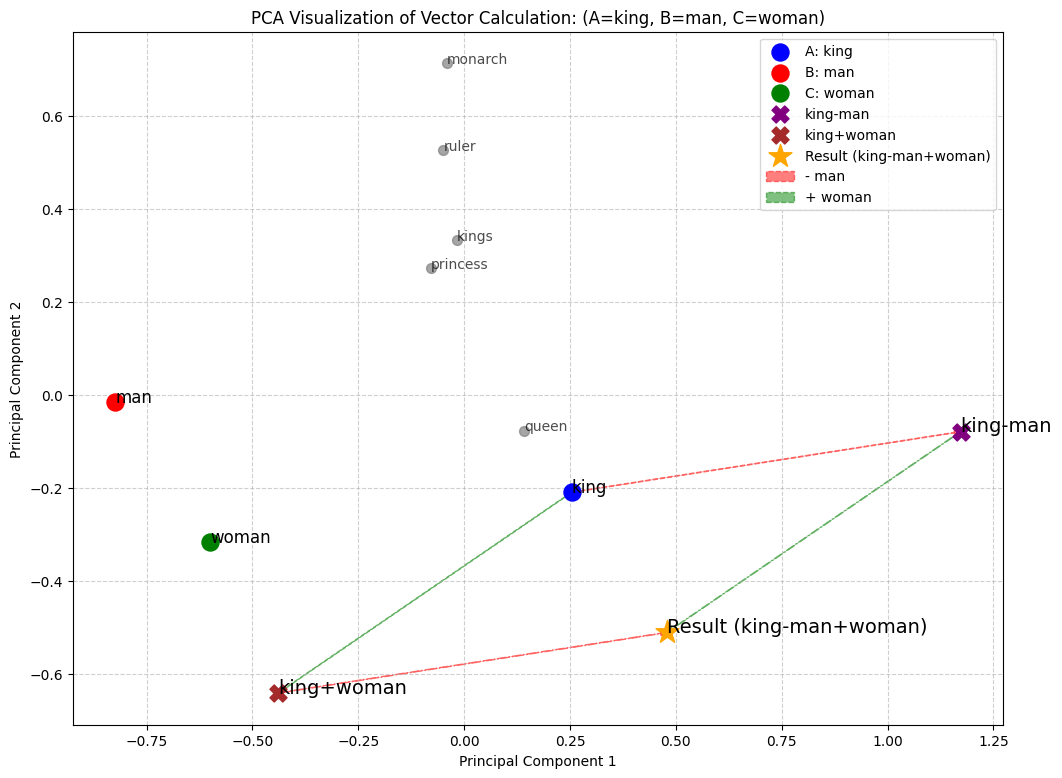

In [ ]:
#@title ベクトル演算 `A - B + C` (計算経路の可視化)

#@markdown ---
#@markdown ### フォーム
#@markdown ベクトル演算 `A - B + C` を実行します。
#@markdown (例: A=king, B=man, C=woman)
wordA = "king" #@param {"type":"string","placeholder":"king"}
wordB = "man" #@param {"type":"string","placeholder":"man"}
wordC = "woman" #@param {"type":"string","placeholder":"woman"}
#@markdown ---
#@markdown ### 可視化オプション
#@markdown 次元削減 (PCA) を用いて、計算結果を2Dプロットします。
enable_visualization = True #@param {type:"boolean"}
#@markdown 上位何件の類似単語をプロットに含めますか？
top_k_to_plot = 7 #@param {type:"slider", min:1, max:20, step:1}
#@markdown ---

import torch.nn.functional as F
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. 埋め込み層の取得 (DistilBERTモデルから)
embedding_layer = model.embeddings.word_embeddings
# 埋め込み行列 (辞書の全単語のベクトル)
embedding_matrix = embedding_layer.weight.data

print(f"辞書の総単語数: {embedding_matrix.shape[0]}")
print(f"ベクトルの次元数: {embedding_matrix.shape[1]}")

# 2. 単語のIDとベクトルを取得
words = [wordA.lower(), wordB.lower(), wordC.lower()]
vectors = {}
all_words_found = True

with torch.no_grad():
    for word in words:
        if not word: # 空文字列チェック
            print("エラー: 単語が入力されていません。")
            all_words_found = False
            break
        try:
            token_id = tokenizer.convert_tokens_to_ids(word)
            if token_id == tokenizer.unk_token_id:
                raise ValueError(f"単語 '{word}' が辞書にありません。")

            token_id_tensor = torch.tensor([token_id]).to(device)
            vectors[word] = embedding_layer(token_id_tensor).squeeze(0) # (1, 768) -> (768)
            print(f"'{word}' のベクトル取得完了。")

        except (ValueError, IndexError) as e:
            print(f"エラー: {e}")
            all_words_found = False
            break

# 3. ベクトル演算
if all_words_found:
    with torch.no_grad():
        vecA = vectors[wordA.lower()]
        vecB = vectors[wordB.lower()]
        vecC = vectors[wordC.lower()]

        # ▼▼▼ 要求された全6点のベクトルを計算 ▼▼▼
        vec_A_minus_B = vecA - vecB   # A - B (関係性ベクトル)
        vec_A_plus_C = vecA + vecC    # A + C (中間計算)
        vec_Result = vecA - vecB + vecC # A - B + C (最終結果)

        # 4. 最終結果 (A-B+C) と全単語の類似度を計算
        result_vec_norm = F.normalize(vec_Result.unsqueeze(0), p=2)
        embedding_matrix_norm = F.normalize(embedding_matrix, p=2)
        cosine_similarities = torch.matmul(result_vec_norm, embedding_matrix_norm.T)

        # 5. 類似度が高い上位単語を取得
        top_k = top_k_to_plot
        top_k_similarities, top_k_indices = torch.topk(cosine_similarities.squeeze(0), top_k)

        print(f"\n--- 計算結果 (vec({wordA}) - vec({wordB}) + vec({wordC})) に近い単語 Top {top_k} ---")

        results = []
        top_result_labels = [] # 可視化用
        top_result_vectors = [] # 可視化用

        for i in range(top_k):
            token_id = top_k_indices[i].item()
            token_str = tokenizer.decode(token_id)
            similarity = top_k_similarities[i].item()
            results.append((token_str, similarity))

            if token_str not in words:
                top_result_labels.append(token_str)
                token_id_tensor = torch.tensor([token_id]).to(device)
                top_result_vectors.append(embedding_layer(token_id_tensor).squeeze(0))

        df_results = pd.DataFrame(results, columns=["Word", "Cosine Similarity"])
        print(df_results.to_string(index=False))

    # --- 6. ▼▼▼ 可視化機能（要求された6点と4矢印） ▼▼▼ ---
    if enable_visualization:
        print("\n--- 2D可視化 (PCA) ---")

        # 1. 収集するベクトルとラベル
        labels_to_plot = [wordA, wordB, wordC]
        vectors_to_plot = [vecA, vecB, vecC]

        labels_to_plot.extend(top_result_labels)
        vectors_to_plot.extend(top_result_vectors)

        # ▼▼▼ A-B, A+C, Result もPCAの対象に含める ▼▼▼
        ab_label = f"{wordA}-{wordB}"
        ac_label = f"{wordA}+{wordC}"
        result_label = f"Result ({wordA}-{wordB}+{wordC})"

        labels_to_plot.extend([ab_label, ac_label, result_label])
        vectors_to_plot.extend([vec_A_minus_B, vec_A_plus_C, vec_Result])

        # 2. PyTorchテンソルをNumPy配列に変換
        vectors_np = torch.stack(vectors_to_plot).cpu().numpy()

        # 3. PCAで2次元に削減
        pca = PCA(n_components=2)
        vectors_2d = pca.fit_transform(vectors_np)

        # 4. プロット
        plt.figure(figsize=(12, 9))

        # 座標を辞書に
        coords = {label: vectors_2d[i] for i, label in enumerate(labels_to_plot)}

        # A, B, C をプロット
        plt.scatter(coords[wordA][0], coords[wordA][1], c='blue', s=150, label=f"A: {wordA}", zorder=5)
        plt.annotate(wordA, (coords[wordA][0], coords[wordA][1]), fontsize=12, zorder=6)

        plt.scatter(coords[wordB][0], coords[wordB][1], c='red', s=150, label=f"B: {wordB}", zorder=5)
        plt.annotate(wordB, (coords[wordB][0], coords[wordB][1]), fontsize=12, zorder=6)

        plt.scatter(coords[wordC][0], coords[wordC][1], c='green', s=150, label=f"C: {wordC}", zorder=5)
        plt.annotate(wordC, (coords[wordC][0], coords[wordC][1]), fontsize=12, zorder=6)

        # 計算結果 (A-B) をプロット
        plt.scatter(coords[ab_label][0], coords[ab_label][1], c='purple', s=150, marker='X', label=ab_label, zorder=10)
        plt.annotate(ab_label, (coords[ab_label][0], coords[ab_label][1]), fontsize=14, zorder=11)

        # 計算結果 (A+C) をプロット
        plt.scatter(coords[ac_label][0], coords[ac_label][1], c='brown', s=150, marker='X', label=ac_label, zorder=10)
        plt.annotate(ac_label, (coords[ac_label][0], coords[ac_label][1]), fontsize=14, zorder=11)

        # 最終計算結果 (Result) をプロット
        plt.scatter(coords[result_label][0], coords[result_label][1], c='orange', s=300, marker='*', label=result_label, zorder=10)
        plt.annotate(result_label, (coords[result_label][0], coords[result_label][1]), fontsize=14, zorder=11)

        # Top-k の結果をプロット
        for label in top_result_labels:
            plt.scatter(coords[label][0], coords[label][1], c='gray', s=50, alpha=0.7)
            plt.annotate(label, (coords[label][0], coords[label][1]), alpha=0.7)

        # 6. ▼▼▼ 要求された4つの矢印 ▼▼▼

        # 矢印1: A -> A-B (赤色, -B)
        plt.arrow(coords[wordA][0], coords[wordA][1],
                  coords[ab_label][0] - coords[wordA][0],
                  coords[ab_label][1] - coords[wordA][1],
                  color='red', linestyle='--', head_width=0.01, length_includes_head=True, alpha=0.5, label=f"- {wordB}")

        # 矢印2: A -> A+C (緑色, +C)
        plt.arrow(coords[wordA][0], coords[wordA][1],
                  coords[ac_label][0] - coords[wordA][0],
                  coords[ac_label][1] - coords[wordA][1],
                  color='green', linestyle='--', head_width=0.01, length_includes_head=True, alpha=0.5, label=f"+ {wordC}")

        # 矢印3: A+C -> Result (赤色, -B)
        plt.arrow(coords[ac_label][0], coords[ac_label][1],
                  coords[result_label][0] - coords[ac_label][0],
                  coords[result_label][1] - coords[ac_label][1],
                  color='red', linestyle='-.', head_width=0.01, length_includes_head=True, alpha=0.5)

        # 矢印4: A-B -> Result (緑色, +C)
        plt.arrow(coords[ab_label][0], coords[ab_label][1],
                  coords[result_label][0] - coords[ab_label][0],
                  coords[result_label][1] - coords[ab_label][1],
                  color='green', linestyle='-.', head_width=0.01, length_includes_head=True, alpha=0.5)

        plt.title(f"PCA Visualization of Vector Calculation: (A={wordA}, B={wordB}, C={wordC})")
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

> 👩‍🎓 **課題 (ステップ0 考察・穴埋め)**
>
> 1.  上のセルのフォーム機能を使って、`king - man + woman` 以外のアナロジー（類推）計算を試してみましょう。
>     * 例: `Paris - France + Japan` （首都の関係）
>     * 例: `walking - walk + swam` （動詞の時制の関係）
> 2.  （穴埋め） Word2Vec は、大量の文章を学習し、単語を「埋め込み＿＿＿＿＿」として表現します。このベクトルでは、単語の＿＿＿＿＿がベクトル空間上の「位置」や「向き（関係性）」として表現されます。
>
>     例えば、`king - man` が表す「男性から王様への関係性」のベクトルと、`queen - woman` が表す「＿＿＿＿＿から女王への関係性」のベクトルが、空間上でほぼ同じ向きになります。このように、単語を計算可能なベクトルに変換することで、コンピュータは単語の＿＿＿＿＿を扱えるようになります。
> 3.  このグラフは、ベクトル演算 `A - B + C = Result` が `A - B = Result - C` という関係（平行四辺形）で視覚化できることを示しています。このことから、`A - B`（例: `king - man`）のベクトルは、どのような「意味」や「関係性」を持っていると解釈できるか、あなたの考えを説明してください。（自由記述）

----

# 📝 ステップ1: (BERT) 埋め込みベクトルと「文脈」の問題

ステップ0では、Word2Vec (GloVe) が単語の意味をベクトル（空間上の位置）で表現できることを見ました。

しかし、Word2Vecには大きな問題があります。それは「**多義語**」を区別できないことです。
Word2Vecでは、`bank`（銀行）と `bank`（土手）は、辞書に1つの単語として登録されているため、**常に同じベクトル**になってしまいます。これでは、文脈を正しく理解できません。

この「文脈」の問題を解決したのが、**Transformer** という技術です。

---
### 🧠 Transformer, BERT, GPT とは？

この課題では `BERT` や `GPT` というモデルを使います。これらは全て `Transformer` という強力なAIモデル（設計図）をベースにしています。

（RNN、LSTMといった技術を知らなくても、以下の説明で進められます。）

* **Transformer (トランスフォーマー):**
    * 2017年に登場した、AIモデルの「設計図」あるいは「アーキテクチャ」の名前です。
    * 文章の中の「どの単語とどの単語が強く関係しているか」（＝文脈）を非常にうまく扱うことができます。この中核技術が「**Attention**（アテンション）」（ステップ2で学びます）です。

* **BERT (バート):**
    * `Transformer` の設計図を使って「**文脈を深く理解する**」ためにGoogleが訓練したモデルです。
        * 「感情分析」や「質問応答」など様々なタスクに使われます（これは **ファインチューニング** と呼ばれます）。
        * しかし、そのための「基礎体力」を作る訓練（**事前学習**）として、BERTが（下記のGPTとは異なる方法で）解くのが「**穴埋め問題**（Masked Language Model）」です。
    * **なぜ穴埋め問題か？** それは、文の**両側**（左右）の文脈を同時に見るようにモデルを強制できるからです。
        * 例えば、`I went to the [?] to deposit money.` (私はお金をおろしに [?] に行った) という穴埋めを解くには、左側の `went to the` だけでなく、右側の `deposit money` を見ることが不可欠です。
        * このように両側の文脈を見る訓練（事前学習）を大量に行うことで、BERTは「単語の文脈上の深い意味」を理解するようになります。この「賢くなったBERT」をベースとして、感情分析などの応用タスクを（ファインチューニングで）解かせるわけです。

* **GPT (ジーピーティー):**
    * `Transformer` の設計図を使って「**次の単語を予測する**」ためにOpenAIが訓練したモデルです。
    * 主な目的は、文章の続きを生成すること（例: "I sat on the river" → `bank`）です。
    * 文の**左側**（すでに入力された部分）だけを参照して、次に来る単語を予測します。

なお、今回の課題のゴールは、このGPTの仕組みを理解することです。



In [ ]:
#@title 模式図を表示
from IPython.display import display, HTML

# 埋め込みたいSVGコード（BERT vs GPT）をPython文字列として定義します
# (コピー時に欠けていた可能性のある箇所を修正しています)
svg_code_string = """
<svg width="900px" viewBox="0 0 800 500" xmlns="http://www.w3.org/2000/svg">
    <text x="400" y="30" font-size="24" font-weight="bold" text-anchor="middle" fill="#333">
    BERT vs GPT: Attention Patterns
  </text>

    <g id="bert-section">
        <text x="200" y="80" font-size="20" font-weight="bold" text-anchor="middle" fill="#1976D2">
      BERT (Bidirectional)
    </text>
    <text x="200" y="105" font-size="14" text-anchor="middle" fill="#666">
      Masked Language Model
    </text>

        <g id="bert-words">
      <rect x="40" y="130" width="60" height="40" rx="5" fill="#E3F2FD" stroke="#1976D2" stroke-width="2"/>
      <text x="70" y="155" font-size="14" text-anchor="middle" fill="#333">I went</text>

      <rect x="110" y="130" width="60" height="40" rx="5" fill="#E3F2FD" stroke="#1976D2" stroke-width="2"/>
      <text x="140" y="155" font-size="14" text-anchor="middle" fill="#333">to the</text>

      <rect x="180" y="130" width="60" height="40" rx="5" fill="#FF6B6B" stroke="#D32F2F" stroke-width="3"/>
      <text x="210" y="155" font-size="14" font-weight="bold" text-anchor="middle" fill="#FFF">[MASK]</text>

      <rect x="250" y="130" width="60" height="40" rx="5" fill="#E3F2FD" stroke="#1976D2" stroke-width="2"/>
      <text x="280" y="155" font-size="14" text-anchor="middle" fill="#333">to</text>

      <rect x="320" y="130" width="60" height="40" rx="5" fill="#E3F2FD" stroke="#1976D2" stroke-width="2"/>
      <text x="350" y="155" font-size="14" text-anchor="middle" fill="#333">deposit</text>
    </g>

        <defs>
      <marker id="arrowhead-blue" markerWidth="10" markerHeight="10" refX="9" refY="3" orient="auto">
        <polygon points="0 0, 10 3, 0 6" fill="#1976D2" />
      </marker>
    </defs>

        <path d="M 100 145 Q 150 110 185 145" fill="none" stroke="#1976D2" stroke-width="2" marker-end="url(#arrowhead-blue)" opacity="0.7"/>
    <path d="M 170 145 Q 180 120 195 145" fill="none" stroke="#1976D2" stroke-width="2" marker-end="url(#arrowhead-blue)" opacity="0.7"/>

        <path d="M 280 145 Q 250 110 225 145" fill="none" stroke="#1976D2" stroke-width="2" marker-end="url(#arrowhead-blue)" opacity="0.7"/>
    <path d="M 350 145 Q 280 100 220 145" fill="none" stroke="#1976D2" stroke-width="2" marker-end="url(#arrowhead-blue)" opacity="0.7"/>

        <text x="210" y="205" font-size="16" font-weight="bold" text-anchor="middle" fill="#4CAF50">↓</text>
    <rect x="170" y="210" width="80" height="35" rx="5" fill="#C8E6C9" stroke="#4CAF50" stroke-width="2"/>
    <text x="210" y="232" font-size="14" font-weight="bold" text-anchor="middle" fill="#2E7D32">bank</text>
  </g>

    <g id="gpt-section">
        <text x="600" y="80" font-size="20" font-weight="bold" text-anchor="middle" fill="#7B1FA2">
      GPT (Unidirectional)
    </text>
    <text x="600" y="105" font-size="14" text-anchor="middle" fill="#666">
      Next Token Prediction
    </text>

        <g id="gpt-words">
      <rect x="460" y="130" width="50" height="40" rx="5" fill="#F3E5F5" stroke="#7B1FA2" stroke-width="2"/>
s.
      <text x="485" y="155" font-size="14" text-anchor="middle" fill="#333">I sat</text>

      <rect x="520" y="130" width="50" height="40" rx="5" fill="#F3E5F5" stroke="#7B1FA2" stroke-width="2"/>
      <text x="545" y="155" font-size="14" text-anchor="middle" fill="#333">on</text>

      <rect x="580" y="130" width="50" height="40" rx="5" fill="#F3E5F5" stroke="#7B1FA2" stroke-width="2"/>
      <text x="605" y="155" font-size="14" text-anchor="middle" fill="#333">the</text>

      <rect x="640" y="130" width="50" height="40" rx="5" fill="#F3E5F5" stroke="#7B1FA2" stroke-width="2"/>
      <text x="665" y="155" font-size="14" text-anchor="middle" fill="#333">river</text>

      <rect x="700" y="130" width="50" height="40" rx="5" fill="#FFE0B2" stroke="#F57C00" stroke-width="3"/>
      <text x="725" y="155" font-size="14" font-weight="bold" text-anchor="middle" fill="#E65100">?</text>
    </g>

        <defs>
      <marker id="arrowhead-purple" markerWidth="10" markerHeight="10" refX="9" refY="3" orient="auto">
        <polygon points="0 0, 10 3, 0 6" fill="#7B1FA2" />
      </marker>
    </defs>

        <path d="M 510 145 Q 600 110 705 145" fill="none" stroke="#7B1FA2" stroke-width="2" marker-end="url(#arrowhead-purple)" opacity="0.7"/>
    <path d="M 570 145 Q 640 120 705 145" fill="none" stroke="#7B1FA2" stroke-width="2" marker-end="url(#arrowhead-purple)" opacity="0.7"/>
    <path d="M 630 145 Q 670 130 705 145" fill="none" stroke="#7B1FA2" stroke-width="2" marker-end="url(#arrowhead-purple)" opacity="0.7"/>
    <path d="M 690 150 L 705 150" fill="none" stroke="#7B1FA2" stroke-width="2" marker-end="url(#arrowhead-purple)" opacity="0.7"/>

        <text x="725" y="205" font-size="16" font-weight="bold" text-anchor="middle" fill="#4CAF50">↓</text>
    <rect x="685" y="210" width="80" height="35" rx="5" fill="#C8E6C9" stroke="#4CAF50" stroke-width="2"/>
    <text x="725" y="232" font-size="14" font-weight="bold" text-anchor="middle" fill="#2E7D32">bank</text>
  </g>
 s
    <g id="explanations">
        <rect x="30" y="280" width="340" height="180" rx="8" fill="#F5F5F5" stroke="#1976D2" stroke-width="2"/>
    <text x="200" y="305" font-size="16" font-weight="bold" text-anchor="middle" fill="#1976D2">
      Bidirectional Context
    </text>
    <text x="40" y="330" font-size="13" fill="#333">
      • Sees words from BOTH directions
    </text>
    <text x="40" y="355" font-size="13" fill="#333">
      • [MASK] token attends to all words
    </text>
    <text x="40" y="380" font-size="13" fill="#333">
      • Training: Predict masked words
    </text>
    <text x="40" y="405" font-size="13" fill="#333">
      • Best for: Understanding tasks
    </text>
    <text x="40" y="430" font-size="13" fill="#333">
      (classification, Q&amp;A, NER)
    </text>

        <rect x="430" y="280" width="340" height="180" rx="8" fill="#F5F5F5" stroke="#7B1FA2" stroke-width="2"/>
    <text x="600" y="305" font-size="16" font-weight="bold" text-anchor="middle" fill="#7B1FA2">
      Unidirectional (Causal)
    </text>
    <text x="440" y="330" font-size="13" fill="#333">
      • Sees words from LEFT only
    </text>
    <text x="440" y="355" font-size="13" fill="#333">
      • Next token attends to past only
    </text>
    <text x="440" y="380" font-size="13" fill="#333">
      • Training: Predict next word
    </text>
    <text x="440" y="405" font-size="13" fill="#333">
      • Best for: Generation tasks
    </text>
    <text x="440" y="430" font-size="13" fill="#333">
      (text completion, dialogue)
    </text>
  </g>

    <rect x="150" y="470" width="500" height="25" rx="5" fill="#FFF9C4" stroke="#F57F17" stroke-width="2"/>
  <text x="400" y="488" font-size="14" font-weight="bold" text-anchor="middle" fill="#F57F17">
    Key: BERT learns context, GPT learns to continue
  </text>
</svg>
"""

# HTML() を使って表示します
display(HTML(svg_code_string))

---
### 埋め込み「層（Layer）」とは？

`Transformer`（BERTやGPT）も、Word2Vecと同様に、まず単語をベクトルに変換する仕組みを持っています。これが「埋め込み」であり、それを行うのが「埋め込み層」です。

> **層（Layer）とは？**
> AIモデル（ニューラルネットワーク）は、特定の処理を行う「**部品**」を何層にも重ねて作られています。この「部品」のことを「**層（Layer）**」と呼びます。
>
> **埋め込み層（Embedding Layer）とは？**
> 「埋め込み層」は、その部品（層）の一つで、モデルの一番最初の入り口にあります。
> その役割は、**巨大な「辞書（対応表）」を持つこと**です。
>
> 1.  入力として「単語のID番号」（例: `apple` = 5025番）を受け取ります。
> 2.  「埋め込み層」が持っている辞書テーブルから、「5025番に対応するベクトル（例: 768次元の数値リスト）」を引き出します。
> 3.  そのベクトルを、次の層（ステップ2で学ぶAttention層など）に渡します。

> **埋め込み（Embedding）とは？**
> この「埋め込み層」によって変換された「単語を表すベクトル」のこと、あるいは「ベクトルに変換する処理」そのものを指します。
>
> * **古い方法 (One-Hot):** `apple` = `[0, 0, 1, 0, ...]` のように、単語の場所だけ1にする方法。これでは単語同士の類似性が分かりません。
> * **今の方法 (Word2Vec, BERTなど):** 「単語の意味は、周囲の単語によって決まる」（**分布仮説**）に基づき、意味が近い単語がベクトル空間上でも近くに配置されるよう、埋め込み層の「辞書テーブル（ベクトル）」を学習させます。

### BERTの埋め込みは「初期値」

Word2VecとBERT/GPTの大きな違いは、この埋め込みベクトルの使い方です。

* **Word2Vec:** `bank` のベクトル（辞書の値）は一度計算されたら固定です。
* **BERT/GPT:** 埋め込み層が持つベクトルは、あくまで「**初期値**」（文脈を考慮する前の、単語の基本的な意味）です。

BERTやGPTは、`Transformer` の中核技術である「**Attention**」（ステップ2で学びます）を使って、文脈（"river" や "money"）に応じて、この初期値のベクトルを「文脈を反映したベクトル」に動的に作り変えます。

このステップでは、まずBERT（軽量版の `DistilBERT`）の「初期値」である埋め込み層の動作を確認します。
Word2Vecと同様に、**この段階ではまだ文脈が反映されていない**（＝ `bank` のベクトルが文脈によらず同じである）ことを見てみましょう。

In [ ]:
#@title 埋め込みベクトルの取得
#@markdown ---
#@markdown ### フォーム
#@markdown 比較したい2つの文と、その文に含まれる「共通の単語」を指定してください。
text1 = "I ate an apple." #@param {type:"string"}
text2 = "I work at Apple." #@param {type:"string"}
common_word = "apple" #@param {type:"string"}
#@markdown ---
#@markdown ### ベクトル表示オプション
#@markdown ベクトルの値をどこまで表示しますか？（-1で全て表示）
display_dimensions = 5 #@param {type:"slider", min:-1, max:768, step:1}
#@markdown ---

from transformers import DistilBertTokenizer, DistilBertModel
import torch
import numpy as np

# 軽量なBERT (DistilBERT) のモデルとトークナイザがロード済みか確認
if 'model' not in globals():
    model_name = "distilbert-base-uncased"
    tokenizer = DistilBertTokenizer.from_pretrained(model_name)
    model = DistilBertModel.from_pretrained(model_name).to(device)
    print("Model and Tokenizer loaded.")

# --- 1. トークナイズ ---
inputs1 = tokenizer(text1, return_tensors="pt").to(device)
inputs2 = tokenizer(text2, return_tensors="pt").to(device)

print(f"文1: {tokenizer.convert_ids_to_tokens(inputs1['input_ids'][0])}")
print(f"文2: {tokenizer.convert_ids_to_tokens(inputs2['input_ids'][0])}")

# --- 2. 共通単語のIDを取得 ---
try:
    token_id = tokenizer.convert_tokens_to_ids(common_word.lower())
    if token_id == tokenizer.unk_token_id:
        raise ValueError(f"単語 '{common_word}' が辞書にありません。")

    print(f"\n'{common_word}' のID番号: {token_id}")
except ValueError as e:
    print(e)
    # ここで処理を中断
    pass

if 'token_id' in locals() and token_id != tokenizer.unk_token_id:
    # --- 3. 埋め込み層からベクトルを取得 ---
    # (モデルの埋め込み層を直接使います)
    embedding_layer = model.embeddings.word_embeddings
    token_id_tensor = torch.tensor([token_id]).to(device)

    with torch.no_grad():
        embedding_vector = embedding_layer(token_id_tensor)

    print(f"\n'{common_word}' の埋め込みベクトルのサイズ: {embedding_vector.shape}")
    print("（これは 768次元のベクトルです）")

    # ▼▼▼ 質問2への回答（ベクトル表示） ▼▼▼
    if display_dimensions == -1:
        print(f"ベクトル全体 (768次元):\n{embedding_vector[0]}")
    else:
        print(f"ベクトルの一部（最初の{display_dimensions}次元）: {embedding_vector[0, :display_dimensions]}")
    # ▲▲▲ 修正ここまで ▲▲▲

    # --- 4. 2つの文での差の確認 ---
    with torch.no_grad():
        embeddings1 = model.embeddings(inputs1['input_ids'])
        embeddings2 = model.embeddings(inputs2['input_ids'])

    index1_list = (inputs1['input_ids'][0] == token_id).nonzero(as_tuple=True)[0]
    index2_list = (inputs2['input_ids'][0] == token_id).nonzero(as_tuple=True)[0]

    if len(index1_list) == 0 or len(index2_list) == 0:
        print(f"\nエラー: '{common_word}' が両方の文に含まれているか確認してください。")
    else:
        index1 = index1_list[0]
        index2 = index2_list[0]
        vec1_embedding = embeddings1[0, index1]
        vec2_embedding = embeddings2[0, index2]

        difference = torch.abs(vec1_embedding - vec2_embedding).sum()
        print(f"\n埋め込み層の段階では、2つの'{common_word}'ベクトルの差は: {difference.item()}")
        if difference.item() < 1e-6:
            print("➡️ 成功: 同じベクトルです。文脈に関わらず固定です。")
        else:
            print("➡️ 失敗？: ベクトルに差があります。")

> 👩‍🎓 **課題**
>
> 1.  上のセルのフォーム機能を使って、`text1`, `text2`, `common_word` を、あなたが考えた別の多義語（例: `bat`, `right`, `fly`など）を含む文に変えてみましょう。
> 2.  `common_word` を変えても、ベクトルの差（difference）が常にほぼゼロになることを確認してください。
> 3.  （考察）なぜこの段階では、文脈が違うのにベクトルが同じになるのか、ステップ1の解説を読んで自分の言葉で説明してください。（自由記述）

# 💡 ステップ2: 文脈で意味が変わる (Contextualization by Attention)

ステップ1では、単語（`apple`）は文脈（「食べる」か「働く」か）に関わらず、同じベクトルでした。
これでは、「果物」と「会社」の区別がつきません。

そこで登場するのが **Attention（アテンション）** 機構です。

Attentionは、ご指摘の通り、「文の中にある他の単語の埋め込みベクトルとともに重み付け」をします。

* "I ate an **apple**." という文では、Attentionは `apple` のベクトルを作るときに、`ate` や `an` に「注目」します。
* "I work at **Apple**." という文では、Attentionは `work` や `at` に「注目」します。

この「注目（Attention）」による重み付け集約の結果、元の「埋め込みベクトル」（文脈なし）が、文脈を反映した「**文脈ベクトル**」（Contextual Vector）に変換されます。

今度は、`DistilBERT` の「埋め込み層」だけでなく、モデル全体（Attention層を含む）に文を入力して、出力されるベクトルがどう変わるか見てみましょう。多義語 `bank`（銀行／土手）で試します。

In [ ]:
#@title 文脈ベクトルの比較
#@markdown ---
#@markdown ### フォーム
#@markdown 比較したい2つの文と、その文に含まれる「共通の単語」を指定してください。
text_context1 = "I sat on the river bank." #@param {type:"string"}
text_context2 = "I went to the bank to deposit money." #@param {type:"string"}
common_word_context = "bank" #@param {type:"string"}
#@markdown ---
#@markdown 比較したい文脈語（文1から）
context_word1 = "river" #@param {type:"string"}
#@markdown 比較したい文脈語（文2から）
context_word2 = "money" #@param {type:"string"}
#@markdown ---

from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. トークナイズ ---
inputs_context1 = tokenizer(text_context1, return_tensors="pt").to(device)
inputs_context2 = tokenizer(text_context2, return_tensors="pt").to(device)

# --- 2. モデル全体に入力 ---
with torch.no_grad():
    outputs_context1 = model(**inputs_context1)
    outputs_context2 = model(**inputs_context2)

contextual_embeddings1 = outputs_context1.last_hidden_state
contextual_embeddings2 = outputs_context2.last_hidden_state

# --- 3. IDを取得 ---
try:
    common_token_id = tokenizer.convert_tokens_to_ids(common_word_context.lower())
    context1_token_id = tokenizer.convert_tokens_to_ids(context_word1.lower())
    context2_token_id = tokenizer.convert_tokens_to_ids(context_word2.lower())

    # --- 4. ベクトルを抽出 ---
    common_index1 = (inputs_context1['input_ids'][0] == common_token_id).nonzero(as_tuple=True)[0][0]
    common_index2 = (inputs_context2['input_ids'][0] == common_token_id).nonzero(as_tuple=True)[0][0]

    context1_index = (inputs_context1['input_ids'][0] == context1_token_id).nonzero(as_tuple=True)[0][0]
    context2_index = (inputs_context2['input_ids'][0] == context2_token_id).nonzero(as_tuple=True)[0][0]

    common_vec1_context = contextual_embeddings1[0, common_index1].cpu().numpy()
    common_vec2_context = contextual_embeddings2[0, common_index2].cpu().numpy()

    context1_vec = contextual_embeddings1[0, context1_index].cpu().numpy()
    context2_vec = contextual_embeddings2[0, context2_index].cpu().numpy()

    # --- 5. 比較 (コサイン類似度) ---
    similarity_common = cosine_similarity([common_vec1_context], [common_vec2_context])
    print(f"\n--- 文脈ベクトルの比較 ({common_word_context} vs {common_word_context}) ---")
    print(f"文1の'{common_word_context}' と 文2の'{common_word_context}' のコサイン類似度: {similarity_common[0][0]:.4f}")
    if similarity_common[0][0] < 0.7:
        print("➡️ 成功: 類似度が低く、意味が区別されています。")
    else:
        print("➡️ 注意: 類似度があまり下がりませんでした。")


    # --- 6. (おまけ) 文脈との類似度 ---
    sim1_v_context1 = cosine_similarity([common_vec1_context], [context1_vec])[0][0]
    sim1_v_context2 = cosine_similarity([common_vec1_context], [context2_vec])[0][0]
    sim2_v_context1 = cosine_similarity([common_vec2_context], [context1_vec])[0][0]
    sim2_v_context2 = cosine_similarity([common_vec2_context], [context2_vec])[0][0]

    print("\n--- (おまけ) 文脈との類似度 ---")

    # 可視化 (英語)
    df = pd.DataFrame({
        f"'{common_word_context}' (Context 1)": [sim1_v_context1, sim1_v_context2],
        f"'{common_word_context}' (Context 2)": [sim2_v_context1, sim2_v_context2]
    }, index=[f"'{context_word1}' (from C1)", f"'{context_word2}' (from C2)"])

    plt.figure(figsize=(6, 4))
    sns.heatmap(df, annot=True, cmap="viridis", fmt=".4f")
    plt.title(f"Similarity between '{common_word_context}' and context words")
    plt.show()

except IndexError:
    print(f"\nエラー: フォームに入力された単語が、指定された文に含まれているか確認してください。")
except Exception as e:
    print(f"\nエラーが発生しました: {e}")

> 👩‍🎓 **課題 (ステップ2)**
>
> 1.  上のセルのフォーム機能を使って、ステップ1で試した多義語（例: `bat`）の文を入力してみましょう。
> 2.  ステップ1では類似度が高かった（差がほぼ0だった）のに対し、ステップ2（Attention通過後）では類似度が低くなる（例: 0.7未満）ことを確認してください。
> 3.  （考察）なぜAttentionを通すと、同じ単語でも文脈によってベクトルが変わるのか、ステップ2の解説を読んで自分の言葉で説明してください。（自由記述）

# ✍️ ステップ3: 次の単語を予測する (Generation)

ステップ2では、BERT（の軽量版）が文脈を読んで単語の意味を理解する仕組み（穴埋め問題が得意）を見ました。BERTは文の**両側**（左と右）を見て文脈を判断します。

一方、**GPT** は、ご指摘の通り「**そこまでの文章の意味を集約**」し、「**次の単語**」を予測することに特化しています。左から右へ、一方通行で処理します。

GPTが次の単語を予測するプロセスは、以下の通りです。

1.  入力された文（例: "The quick brown fox"）をトークンに区切ります。
2.  各トークンを「埋め込みベクトル」にします（ステップ1）。
3.  Attention（GPTの場合は、自分より左側の単語にしか注目できない仕組み）を使って、各トークンを「文脈ベクトル」に変換します（ステップ2）。
4.  **重要:** 文の**一番最後**のトークン（この例では `fox`）の「文脈ベクトル」を取り出します。このベクトルが、「"The quick brown fox" まで読んだ時点での文脈の集約」です。
5.  ご指摘の通り、この集約された文脈ベクトル（例: 768次元）を、ある特別な「**全結合層（Linear Layer）**」に入力します。
6.  この全結合層は、**LM Head (Language Model Head)** と呼ばれ、その出力の次元数は、モデルが知っている**辞書の総単語数**（例: 50257次元）になっています。
7.  出力された50257個の数値（**ロジット**と呼ばれます）を、**Softmax** という関数に通すことで、合計が1.0になる「確率」に変換します。
8.  これが、「"The quick brown fox" の次にくる単語の確率分布」です。
9.  確率が最も高い単語（例: `jumps`）を選んだり、確率に基づいてランダムに選んだり（サンプリング）することで、文章が生成されます。

実際に `GPT-2`（GPTの初期の公開モデル）を使って、次の単語の確率が計算される様子を見てみましょう。

In [ ]:
#@title 次単語予測の確率分布
#@markdown ---
#@markdown ### フォーム
#@markdown 次の単語を予測させたい「入力文（プロンプト）」を指定してください。
prompt_text = "The quick brown fox" #@param {type:"string"}
#@markdown 表示したい予測候補の数
top_k_value = 10 #@param {type:"slider", min:1, max:20, step:1}
#@markdown ---

from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch.nn.functional as F

# GPT-2 のモデルとトークナイザがロード済みか確認
if 'model_gpt' not in globals():
    model_name_gpt = "gpt2"
    tokenizer_gpt = GPT2Tokenizer.from_pretrained(model_name_gpt)
    model_gpt = GPT2LMHeadModel.from_pretrained(model_name_gpt).to(device)
    if tokenizer_gpt.pad_token is None:
        tokenizer_gpt.pad_token = tokenizer_gpt.eos_token
        model_gpt.config.pad_token_id = model_gpt.config.eos_token_id
    print("GPT-2 Model and Tokenizer loaded.")

# --- 1. トークナイズ ---
inputs_gpt = tokenizer_gpt(prompt_text, return_tensors="pt").to(device)
input_ids = inputs_gpt['input_ids']

print(f"入力文: '{prompt_text}'")

# 'Ġ' が表示されないように修正
token_ids_list = input_ids[0].tolist()
tokens_display = [tokenizer_gpt.decode([token_id]) for token_id in token_ids_list]
print(f"  -> トークン: {tokens_display}")


# --- 2. モデルに入力 ---
with torch.no_grad():
    outputs_gpt = model_gpt(**inputs_gpt)

# --- 3. ロジットの取得 ---
logits = outputs_gpt.logits
if logits.shape[1] == 0: # 入力が空の場合
     print("エラー: 入力が空です。")
else:
    # --- 4. 「最後のトークン」のロジットを取得 ---
    last_token_logits = logits[0, -1, :]

    # --- 5. Softmax で確率に変換 ---
    probabilities = F.softmax(last_token_logits, dim=-1)

    # --- 6. 確率が高い単語を表示 ---
    top_k_probs, top_k_indices = torch.topk(probabilities, top_k_value)

    print(f"\n--- 「{prompt_text}」の次にくる単語の予測 (Top {top_k_value}) ---")

    results = []
    for i in range(top_k_value):
        token_id = top_k_indices[i].item()
        token_str = tokenizer_gpt.decode(token_id)
        prob = top_k_probs[i].item()
        results.append((token_str, prob * 100))

    df_probs = pd.DataFrame(results, columns=["Predicted Word", "Probability (%)"])
    print(df_probs.to_string(index=False))

    # --- 7. 可視化 (英語) ---
    plt.figure(figsize=(10, 5))
    df_probs.set_index("Predicted Word").plot(kind='bar', legend=False)
    plt.title(f"Next word probabilities for '{prompt_text}'")
    plt.ylabel("Probability (%)")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis='y', linestyle='--', alpha=0.7) # ← 修正後

    plt.tight_layout()
    plt.show()

    # --- 8. 動的な結果の表示 ---
    top_word = df_probs.iloc[0]["Predicted Word"]
    print(f"\n➡️ GPTは '{top_word}' が次に来る確率が最も高いと予測しました！")

> 👩‍🎓 **課題 (ステップ3)**
>
> 1.  上のセルのフォーム機能を使って、`prompt_text` に様々な（英語の）文章を入力してみましょう。
> 2.  （例: "The capital of Japan is", "My hobby is", "I like to eat" など）
> 3.  GPTが予測する「次の単語」は、文脈として妥当でしょうか？ `top_k_value` を変えると、予測候補はどのように変わるか観察してください。
> 4.  （考察）GPTは、なぜ「そこまでの文脈」だけで次の単語を予測できるのでしょうか？ ステップ3の解説（特にLM Head）を読んで、自分の言葉で説明してください。（自由記述）

---
# 振り返り課題（穴埋め）

ここまでのステップで学んだことを、以下の穴埋め問題で振り返りましょう。

（ `...` の部分に当てはまる適切な語句を考えてください）

1.  コンピュータは単語をそのまま扱えないため、「`...`」(Embedding) という、単語を数値のリスト（ベクトル）に変換する層を使います。
2.  ステップ1の段階では、`bank` のような多義語も、文脈に関わらず `...` (同じ/異なる) ベクトルで表現されます。
3.  ステップ2では、`...` (Attention) 機構が、文中の他の単語に「注目」し、元のベクトルを文脈に応じた「文脈ベクトル」に変換しました。
4.  ステップ3のGPTは、文の `...` (最初/最後) のトークンの文脈ベクトルを、「そこまでの文脈の集約」として利用します。
5.  この集約されたベクトルを、出力次元が辞書の総単語数になっている `...` (LM Head / 埋め込み層) と呼ばれる全結合層に入力します。
6.  最後に `...` (Softmax) 関数を使って、辞書の全単語が「次にくる確率」を計算し、テキストを生成します。

---
## 🚀 課題: BERT と GPT の違い

私たちはステップ2・3で `BERT`（の軽量版）を、ステップ3で `GPT` を使いました。どちらも同じ「Transformer」という技術をベースにしていますが、目的が大きく異なります。

### 1. 目的の違い（穴埋め）

以下の説明を読み、`...` に（BERT / GPT）のどちらが入るか考えてみましょう。

* **`...` (BERT)** は、文の**両側**（左右）の文脈を読んで、文中の単語の意味を深く理解するのが得意です。主なタスクは「穴埋め問題（Masked Language Model）」や「文章分類」です。
* **`...` (GPT)** は、文の**左側**（そこまで）の文脈だけを読んで、**次**に来る単語を予測するのが得意です。主なタスクは「文章生成（Generative）」です。

### 2. 「文脈ベクトル」の意味の違い

この目的の違いは、「文脈ベクトル」が何を表しているかに現れます。

* **BERTの文脈ベクトル:**
    * `bank` のベクトルは、その単語「自体」が文脈（"river" や "money"）の中で持つ意味（土手/銀行）を強く表現します。穴埋めに使うため、その単語の意味特定が重要です。
* **GPTの文脈ベクトル:**
    * `bank` のベクトルも文脈（"river"）を読み込みますが、その目的は「`bank` **の次**にくる単語」を予測するための「途中経過」です。
    * GPTが最も重要視するのは、**最後のトークン**のベクトルです。これが「そこまでの全情報の集約」となり、次の単語予測に使われます。

ご指摘の通り、GPTにとって「`bank` が小川か銀行か」の区別は、**次の単語を予測するのに必要な分だけ**行われます。BERTほどその単語自体の意味を突き詰める必要はありません。

### 3. 実践: BERTとGPTの「最後のベクトル」の比較

同じ文をBERTとGPTに入力し、**最後のトークン**（`bank`）のベクトルが、それぞれどの単語と一番似ているか（近いか）を比較してみましょう。

* BERT（`DistilBERT`）は `bank` の意味（`river` に近い）を強く反映するはずです。
* GPT（`GPT-2`）は `bank` の意味も持ちつつ、「次」の予測のための情報を集約しているはずです。

In [ ]:
#@title 🧑‍🎓 BERT vs GPT ベクトル比較

#@markdown ---
#@markdown ### フォーム
#@markdown 比較したい共通の文（最後が多義語だと分かりやすい）
common_text = "I sat on the river bank" #@param {type:"string"}
#@markdown ---

# --- 1. BERT (DistilBERT) でベクトル取得 ---
print("--- 1. BERT (DistilBERT) ---")
inputs_bert = tokenizer(common_text, return_tensors="pt").to(device)
tokens_bert = tokenizer.convert_ids_to_tokens(inputs_bert['input_ids'][0])
print(f"BERT トークン: {tokens_bert}")

with torch.no_grad():
    outputs_bert = model(**inputs_bert)

# BERTの最後のトークン ("bank") のベクトル
# [CLS] トークンが先頭に、[SEP] トークンが末尾に追加されるため、
# 文の最後の単語 'bank' は、リストの最後から2番目 (-2) になります。
last_token_index_bert = -2
bert_last_vec = outputs_bert.last_hidden_state[0, last_token_index_bert, :].cpu().numpy()

# BERTの "river" のベクトル
river_token_id = tokenizer.convert_tokens_to_ids("river")
river_index_bert_list = (inputs_bert['input_ids'][0] == river_token_id).nonzero(as_tuple=True)[0]
if len(river_index_bert_list) == 0:
    print("エラー: BERTトークナイザで 'river' が見つかりません。")
    bert_river_vec = None
else:
    river_index_bert = river_index_bert_list[0]
    bert_river_vec = outputs_bert.last_hidden_state[0, river_index_bert, :].cpu().numpy()


# --- 2. GPT-2 でベクトル取得 ---
print("\n--- 2. GPT-2 ---")
inputs_gpt = tokenizer_gpt(common_text, return_tensors="pt").to(device)

# ▼▼▼ 'Ġ' が表示されないように修正 ▼▼▼
token_ids_gpt_list = inputs_gpt['input_ids'][0].tolist()
tokens_gpt_display = [tokenizer_gpt.decode([token_id]) for token_id in token_ids_gpt_list]
print(f"GPT トークン: {tokens_gpt_display}")
# ▲▲▲ 修正ここまで ▲▲▲

with torch.no_grad():
    # GPTは .last_hidden_state を直接返さないので、.transformer(...) から取得
    gpt_hidden_states = model_gpt.transformer(**inputs_gpt).last_hidden_state

# GPTの最後のトークン ("bank") のベクトル
# (GPT-2は [CLS] や [SEP] を自動で追加しないため、文の最後がリストの最後です)
last_token_index_gpt = -1 # 穴埋め: -1
gpt_last_vec = gpt_hidden_states[0, last_token_index_gpt, :].cpu().numpy()

# GPTの "river" のベクトル
# (GPTのトークナイザは 'Ġriver' のように空白を記号で扱う)
# 'Ġriver' (スペース付き) を優先的に探す
river_token_id_gpt = tokenizer_gpt.convert_tokens_to_ids("Ġriver")
if river_token_id_gpt == tokenizer_gpt.unk_token_id:
    # 見つからなければ 'river' (スペースなし) を探す
    river_token_id_gpt = tokenizer_gpt.convert_tokens_to_ids("river")

river_index_gpt_list = (inputs_gpt['input_ids'][0] == river_token_id_gpt).nonzero(as_tuple=True)[0]
if len(river_index_gpt_list) == 0:
    print("エラー: GPT-2トークナイザで 'river' (または 'Ġriver') が見つかりません。")
    gpt_river_vec = None
else:
    river_index_gpt = river_index_gpt_list[0]
    gpt_river_vec = gpt_hidden_states[0, river_index_gpt, :].cpu().numpy()


# --- 3. 類似度の比較 ---
# 両方のベクトルが正常に取得できた場合のみ実行
if bert_river_vec is not None and gpt_river_vec is not None:
    print("\n--- 3. 類似度比較 ---")

    # BERT: "bank" と "river" の類似度
    sim_bert = cosine_similarity([bert_last_vec], [bert_river_vec]) # 穴埋め: [bert_last_vec], [bert_river_vec]
    print(f"BERT: 最後の 'bank' と 'river' の類似度: {sim_bert[0][0]:.4f}")

    # GPT: "bank" と "river" の類似度
    sim_gpt = cosine_similarity([gpt_last_vec], [gpt_river_vec]) # 穴埋め: [gpt_last_vec], [gpt_river_vec]
    print(f"GPT: 最後の 'bank' と 'river' の類似度: {sim_gpt[0][0]:.4f}")

    print("\n(注: GPT-2は 'river' を ' river' とトークナイズすることがあり、BERTと条件が完全には一致しませんが、傾向を比較します)")
else:
    print(f"\n--- 3. 類似度比較 (スキップ) ---")
    print("文脈語 ('river') が見つからなかったため、類似度比較をスキップしました。")

> 👩‍🎓 **課題 (BERT vs GPT 考察)**
>
> 1.  BERTとGPTで、最後の単語（`bank`）と文脈語（`river`）の類似度にどのような違いが出たでしょうか？
> 2.  （考察）ステップ3で学んだように、GPTはこの「最後のベクトル」を使って**次の単語**を予測します。なぜ、`bank` 自体の意味（`river` に近いかどうか）を突き詰めるよりも、「そこまでの文脈を集約したベクトル」を使う方が、次の単語（例: "and", "is", "was" など）を予測するのに適していると考えられるか、あなたの考えを説明してください。（自由記述）

# 🎉 まとめ

お疲れ様でした！この課題では、GPTのような大規模言語モデルがテキストを生成する3つの基本的なステップを学びました。

1.  **📝 埋め込み (Embedding):**
    単語を「意味を持つ数値ベクトル」に変換します。この時点では、まだ文脈（多義語）は考慮されていません。

2.  **💡 文脈化 (Contextualization):**
    **Attention** という仕組みが、文中の他の単語に「注目」し、元の埋め込みベクトルを「文脈ベクトル」にアップグレードします。これにより `bank` のような多義語も区別できるようになりました。

3.  **✍️ 生成 (Generation):**
    GPTは、**最後の単語の文脈ベクトル**（＝そこまでの文脈の集約）を **LM Head（全結合層）** に通します。これにより、辞書にある全単語の「次の単語としての確率」が計算され、最も確率の高い単語が選ばれます。

今回は、Attention がどのように重みを計算しているか？（Self-Attention や QKV）という核心部分には触れませんでしたが、入力（埋め込み）と出力（文脈ベクトル、確率）がどう変わるかを見ることで、GPT によるテキスト生成の全体像を掴んでいただけたかと思います。